In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install kaggle Pillow imageio matplotlib pandas torchsummary
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download xhlulu/140k-real-and-fake-faces
# # ! kaggle datasets download bwandowando/faces-dataset-using-stable-diffusion-v14

# import shutil
# shutil.unpack_archive('140k-real-and-fake-faces.zip')
# # shutil.unpack_archive('faces-dataset-using-stable-diffusion-v14.zip')

In [1]:
import os
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import datetime
from copy import deepcopy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary
torch.manual_seed(69)
%load_ext tensorboard

In [2]:
# Hyperparameters
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_EPOCHS = 10
BATCH_SIZE = 128
TRAIN_SUBSET_SIZE = 25000
VALID_SUBSET_SIZE = 5000
TEST_SUBSET_SIZE = 5000
LEARNING_RATE = 1e-4
IMAGE_SIZE = 128
CHANNELS_IMG = 3
Z_DIM = 256
NUM_WORKERS = 2

In [3]:
def create_dataloader(
    data_path,
    subset_size,
    batch_size,
    img_size,
    only_real=True
):
    data_transforms = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Normalize(
           [0.5 for _ in range(3)],
           [0.5 for _ in range(3)]),
    ])

    dataset = datasets.ImageFolder(root=data_path, transform=data_transforms)
    if only_real:
      class_idx = dataset.class_to_idx["real"]
      class_indices = [i for i, label in enumerate(dataset.targets) if label == class_idx]
      subset_indices = class_indices[:subset_size]
    else:
      real_class_idx = dataset.class_to_idx["real"]
      real_class_indices = [
          i for i, label in enumerate(dataset.targets) if label == real_class_idx
      ]
      real_subset_indices = real_class_indices[:subset_size//2]

      fake_class_idx = dataset.class_to_idx["fake"]
      fake_class_indices = [
          i for i, label in enumerate(dataset.targets) if label == fake_class_idx
      ]
      fake_subset_indices = fake_class_indices[:subset_size//2]
      subset_indices = real_subset_indices + fake_subset_indices

    subset_dataset = Subset(dataset, subset_indices)
    dataloader = DataLoader(
       subset_dataset,
       batch_size=batch_size,
       shuffle=True,
       num_workers=NUM_WORKERS,
       pin_memory=True,
       drop_last=True
    )
    return dataloader

In [4]:
test_loader = create_dataloader("real_vs_fake/real-vs-fake/test", TEST_SUBSET_SIZE, BATCH_SIZE , IMAGE_SIZE, only_real=False)
print(f"Test \t\t Batches: {len(test_loader)} \t Images: {len(test_loader.dataset)}")

Test 		 Batches: 39 	 Images: 5000


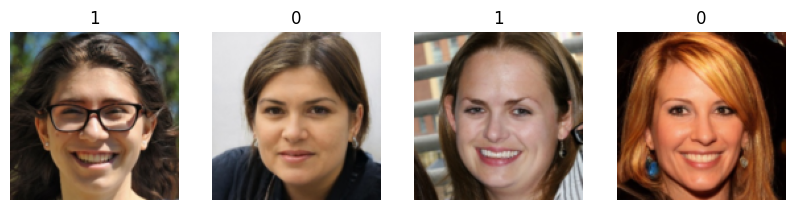

In [5]:
# 1-real    0-fake
batch, labels = next(iter(test_loader))
images = batch[:4]
images = (images + 1) / 2
labels = labels[:4]
plt.figure(figsize=(10, 4))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(images[i].permute(1,2,0))
    plt.title(labels[i].item())
    plt.axis("off")

In [6]:
def load_checkpoint(checkpoint_file, model, optimizer=None, lr=None):
    checkpoint = torch.load(checkpoint_file, map_location="cuda", weights_only=True)
    model.load_state_dict(checkpoint["state_dict"])

    if optimizer is not None:
        optimizer.load_state_dict(checkpoint["optimizer"])

        # If we don't do this then it will just have learning rate of old checkpoint
        # and it will lead to many hours of debugging \:
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
    print("=> Loaded checkpoint")

In [7]:
CHECKPOINT_PRO_CRITIC = "pro_critic_128_2.pth"
CHECKPOINT_PRO_GEN = "pro_generator_128_2.pth"
CHECKPOINT_PRO_DISC = "pro_disc_128_3.pth"
PRO_LR = 5.5e-4
FACTORS = [1, 1/2, 1/4, 1/8, 1/16, 1/32]
CHANNELS_IMG = 3
IN_CHANNELS = 512

In [8]:
class WSConv2d(nn.Module):
    """
    Weight scaled Conv2d (Equalized Learning Rate)
    Note that input is multiplied rather than changing weights
    this will have the same result.

    Inspired and looked at:
    https://github.com/nvnbny/progressive_growing_of_gans/blob/master/modelUtils.py
    """

    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, gain=2
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (gain / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)


class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x

In [9]:
class Generator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()

        # initial takes 1x1 -> 4x4
        self.initial = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )

        # Converts n channel image to rgb channel
        self.initial_vec_to_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )

        self.prog_blocks, self.vec_to_rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_vec_to_rgb]),
        )

        for i in range(
            len(FACTORS) - 1
        ):  # -1 to prevent index error because of factors[i+1]
            conv_in_c = int(in_channels * FACTORS[i])
            conv_out_c = int(in_channels * FACTORS[i + 1])
            self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
            self.vec_to_rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )

    def fade_in(self, alpha, upscaled, generated):
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * generated + (1 - alpha) * upscaled

    def forward(self, x, alpha=0.5, steps=5):
        out = self.initial(x) # 1x1 to 4x4

        if steps == 0:
            return self.initial_vec_to_rgb(out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        # The number of channels in upscale will stay the same, while
        # out which has moved through prog_blocks might change. To ensure
        # we can convert both to rgb we use different vec_to_rgb_layers
        # (steps-1) and steps for upscaled, out respectively
        final_upscaled = self.vec_to_rgb_layers[steps - 1](upscaled)
        final_out = self.vec_to_rgb_layers[steps](out)
        return torch.tanh(self.fade_in(alpha, final_upscaled, final_out))

pro_gen = Generator(
    Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG
).to(DEVICE)
opt_pro_gen = optim.Adam(
    pro_gen.parameters(), lr=1e-3, betas=(0.0, 0.99)
)

load_checkpoint(CHECKPOINT_PRO_GEN, pro_gen)

pro_gen.eval()

=> Loaded checkpoint


Generator(
  (initial): Sequential(
    (0): PixelNorm()
    (1): ConvTranspose2d(256, 512, kernel_size=(4, 4), stride=(1, 1))
    (2): LeakyReLU(negative_slope=0.2)
    (3): WSConv2d(
      (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (4): LeakyReLU(negative_slope=0.2)
    (5): PixelNorm()
  )
  (initial_vec_to_rgb): WSConv2d(
    (conv): Conv2d(512, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (prog_blocks): ModuleList(
    (0): ConvBlock(
      (conv1): WSConv2d(
        (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv2): WSConv2d(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (leaky): LeakyReLU(negative_slope=0.2)
      (pn): PixelNorm()
    )
    (1): ConvBlock(
      (conv1): WSConv2d(
        (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (c

In [10]:
class Discriminator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_to_vec_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb_to_vec layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(FACTORS) - 1, 0, -1):
            conv_in = int(in_channels * FACTORS[i])
            conv_out = int(in_channels * FACTORS[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            self.rgb_to_vec_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb_to_vec" this is just the RGBto_vec layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb_to_vec
        self.initial_rgb_to_vec = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_to_vec_layers.append(self.initial_rgb_to_vec)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha=0.5, steps=5):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb_to_vec as initial step, this will depend on
        # the image size (each will have it's on rgb_to_vec layer)
        out = self.leaky(self.rgb_to_vec_layers[cur_step](x))

        if steps != 0:# i.e, image is anything other than 4x4
            # because prog_blocks might change the channels, for down scale we use rgb_to_vec_layer
            # from previous/smaller size which in our case correlates to +1 in the indexing
            downscaled = self.leaky(self.rgb_to_vec_layers[cur_step + 1](self.avg_pool(x)))
            out = self.avg_pool(self.prog_blocks[cur_step](out))

            # the fade_in is done first between the downscaled and the input
            # this is opposite from the generator
            out = self.fade_in(alpha, downscaled, out)

            for step in range(cur_step + 1, len(self.prog_blocks)):
                out = self.prog_blocks[step](out)
                out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

pro_disc = Discriminator(
    Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG
).to(DEVICE)
opt_pro_disc = optim.Adam(
    pro_disc.parameters(), lr=1e-3, betas=(0.0, 0.99)
)

load_checkpoint(CHECKPOINT_PRO_DISC, pro_disc, opt_pro_disc, PRO_LR,)

pro_disc.final_block.pop(4)
pro_disc.final_block.pop(3)
pro_disc.final_block.add_module('Flatten', nn.Flatten())

for param in pro_disc.parameters():
    param.requires_grad = False

pro_disc.eval()

=> Loaded checkpoint


Discriminator(
  (prog_blocks): ModuleList(
    (0): ConvBlock(
      (conv1): WSConv2d(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv2): WSConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (leaky): LeakyReLU(negative_slope=0.2)
      (pn): PixelNorm()
    )
    (1): ConvBlock(
      (conv1): WSConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv2): WSConv2d(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (leaky): LeakyReLU(negative_slope=0.2)
      (pn): PixelNorm()
    )
    (2): ConvBlock(
      (conv1): WSConv2d(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv2): WSConv2d(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), b

In [13]:
batch, labels = next(iter(test_loader))
batch = batch.to(DEVICE)
pro_disc(batch).squeeze().shape

torch.Size([128, 512])

torch.Size([3, 128, 128])
True label: tensor(0)
Predicted label: tensor(nan, device='cuda:0')


<ipython-input-27-d8cfd270d082>:50: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])


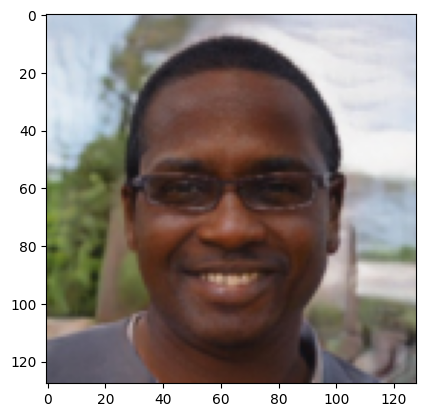

In [28]:
# For real
with torch.no_grad():
  for i, labels in test_loader:
      image = i[0]
      print(image.shape)
      plt.imshow((image.permute(1, 2, 0) + 1)/2)
      label = labels[0]
      image = image[None,:,:,:]
      image = image.to(DEVICE)
      print("True label:", label.squeeze())
      print("Predicted label:", pro_disc(image).squeeze())
      break

torch.Size([3, 128, 128])
True label: 0
Predicted label: tensor(nan, device='cuda:0', grad_fn=<SqueezeBackward0>)


<ipython-input-54-1a9f54b52534>:50: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])


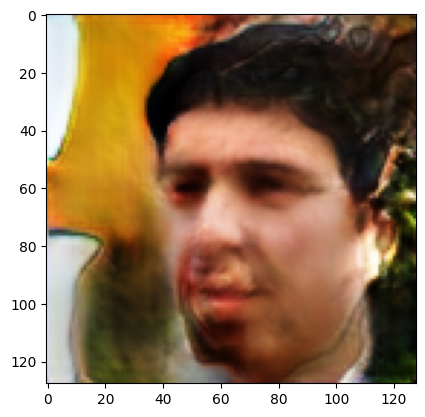

In [58]:
# For fake
for i, labels in test_loader:
    image = pro_gen(torch.randn(1, Z_DIM, 1, 1).to(DEVICE)).to(DEVICE)
    image = image[0]
    print(image.shape)
    plt.imshow((image.cpu().detach().permute(1, 2, 0) + 1)/2)
    label = 0
    image = image[None,:,:,:]
    image = image.to(DEVICE)
    print("True label:", label)
    print("Predicted label:", pro_disc(image).squeeze())
    break